In [1]:
import pandas as pd
import numpy as np
import os
import cv2 # 이미지 처리
from PIL import Image # 이미지 처리 (선택적)
import matplotlib.pyplot as plt # 시각화
import seaborn as sns # 시각화 (matplotlib 기반)

# Jupyter Notebook/Google Colab에서 plot이 보이도록 설정
%matplotlib inline

# 데이터 경로 수정
data_dir = 'diabetic-retinopathy-detection'  # 데이터 폴더명
data_path = os.path.join(data_dir, 'trainLabels.csv')  # CSV 파일 경로
base_image_dir = os.path.join(data_dir, 'train')       # 이미지 폴더 경로

# CSV 불러오기
df = pd.read_csv(data_path)

# 레이블 매핑 (이전 코드에서 사용했던 매핑)
label_mapping = {
    'No_DR':0,
    'Mild':1,
    'Moderate':2,
    'Severe':3,
    'Proliferate_DR':4
}
# 역매핑도 준비해두면 시각화에 편리합니다.
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

print(f"Loaded DataFrame head:\n{df.head()}")
print(f"Total images in DataFrame: {len(df)}")

Loaded DataFrame head:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
Total images in DataFrame: 35126


**이미지 형식, 해상도, 크기 분포 확인**



Finished collecting metadata.
Missing images count: 0

--- Image Resolution Distribution ---
3888x2592    10352
4752x3168     5550
3504x2336     4144
2560x1920     3858
2592x1944     3795
3456x2304     1628
4928x3264     1558
4272x2848      854
3008x2000      836
2816x1880      508
1792x1184      414
4288x2848      322
3215x2136      298
3072x2048      264
2496x1664      178
3088x2056      166
2196x1957      116
3264x2448      108
3872x2592       66
5184x3456       26
2124x2056       24
400x315         19
2544x1696       16
1620x1444       10
1444x1444        6
2048x1536        4
433x289          2
1600x1216        2
2500x1666        2
Name: count, dtype: int64


C:\Users\asia\AppData\Local\Temp\ipykernel_32536\4116756146.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resolution_counts.index[:10], y=resolution_counts.values[:10], palette='viridis')


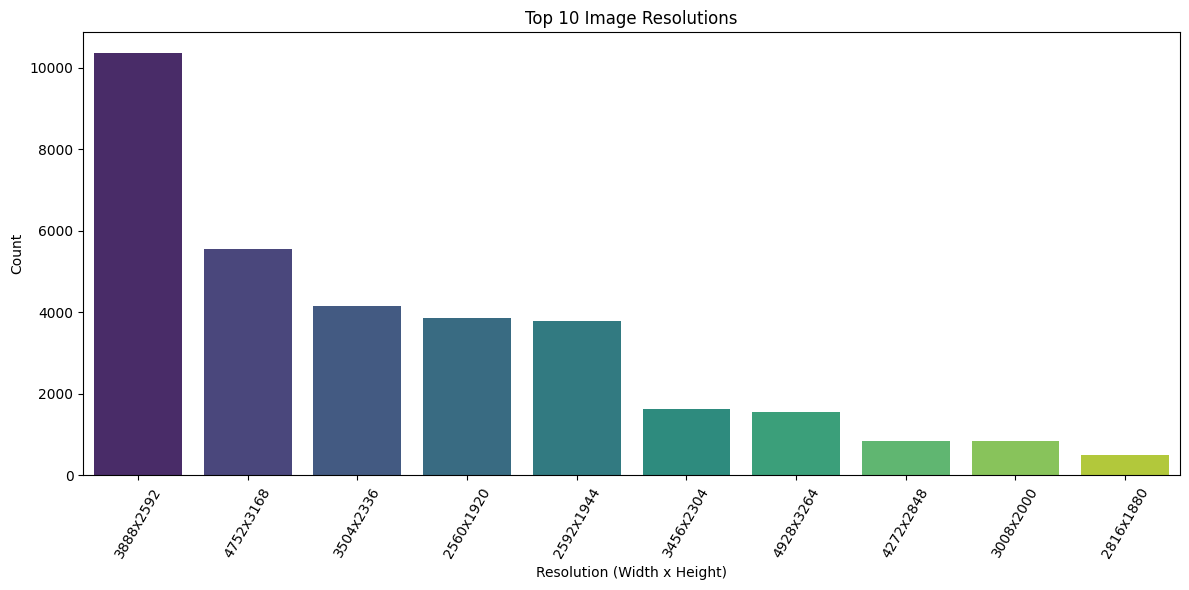


--- Image Channel Distribution ---
3    35126
Name: count, dtype: int64

--- Image Format Distribution ---
.jpeg    35126
Name: count, dtype: int64


In [9]:
# --- 이미지 메타데이터 수집 코드 수정 ---
image_resolutions = []
image_channels = []
image_formats = []
missing_images = []

print("\nCollecting image metadata (this might take a while for large datasets)...")

# ProgressBar를 위한 TQDM (선택 사항, Colab이나 Jupyter에서 진행 상황 확인에 유용)
# from tqdm.notebook import tqdm # Jupyter/Colab용
# for index, row in tqdm(df.iterrows(), total=len(df), desc="Collecting Metadata"):

for index, row in df.iterrows():
    # 새 데이터셋에서는 'image' 컬럼이 이미지 파일 이름을 나타냅니다.
    img_filename = row['image'] + '.jpeg' # 'image' 컬럼 값 + '.jpeg'

    # 이미지 파일 경로 구성:
    # 가장 흔한 경우는 모든 이미지가 base_image_dir 바로 아래에 있는 경우입니다.
    # 예: 'all_images/10_left.png'
    img_path = os.path.join(base_image_dir, img_filename)

    # 만약 이미지가 'level' (진단 단계)별 폴더에 나뉘어 있다면 아래와 같이 수정:
    # img_path = os.path.join(base_image_dir, str(row['level']), img_filename)
    # 예: 'colored_images/0/10_left.png'

    if os.path.exists(img_path):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR) # 컬러 이미지로 로드
            if img is not None:
                h, w, c = img.shape # 높이, 너비, 채널 수
                image_resolutions.append(f"{w}x{h}") # 가로x세로 형태로 저장
                image_channels.append(c)
                image_formats.append(os.path.splitext(img_path)[1]) # 파일 확장자 (예: .png)
            else:
                print(f"Warning: Could not read image at {img_path}. It might be corrupted.")
                missing_images.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            missing_images.append(img_path)
    else:
        # print(f"Image not found: {img_path}") # 너무 많으면 주석 처리
        missing_images.append(img_path) # 누락된 이미지 경로를 리스트에 추가

print(f"\nFinished collecting metadata.")
print(f"Missing images count: {len(missing_images)}")
if len(missing_images) > 0:
    print(f"Sample missing images: {missing_images[:5]}")

# --- EDA 결과 출력 및 시각화 (기존 코드와 동일, 컬럼명만 'level'로 변경) ---

# 해상도 분포
print("\n--- Image Resolution Distribution ---")
resolution_counts = pd.Series(image_resolutions).value_counts()
print(resolution_counts)
# 가장 흔한 해상도 몇 개 시각화 (상위 10개)
plt.figure(figsize=(12, 6)) # 플롯 크기 확대
sns.barplot(x=resolution_counts.index[:10], y=resolution_counts.values[:10], palette='viridis')
plt.title('Top 10 Image Resolutions')
plt.xlabel('Resolution (Width x Height)')
plt.ylabel('Count')
plt.xticks(rotation=60) # x축 라벨 회전
plt.tight_layout() # 레이아웃 조정
plt.show()

# 채널 수 분포
print("\n--- Image Channel Distribution ---")
channel_counts = pd.Series(image_channels).value_counts()
print(channel_counts)
# 대부분 3 (컬러 이미지)일 것입니다.

# 이미지 형식 분포
print("\n--- Image Format Distribution ---")
format_counts = pd.Series(image_formats).value_counts()
print(format_counts)


**클래스별 이미지 수 확인**


--- Class Distribution ---
level
0    25810
1     2443
2     5292
3      873
4      708
Name: count, dtype: int64


C:\Users\asia\AppData\Local\Temp\ipykernel_32264\3014654075.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


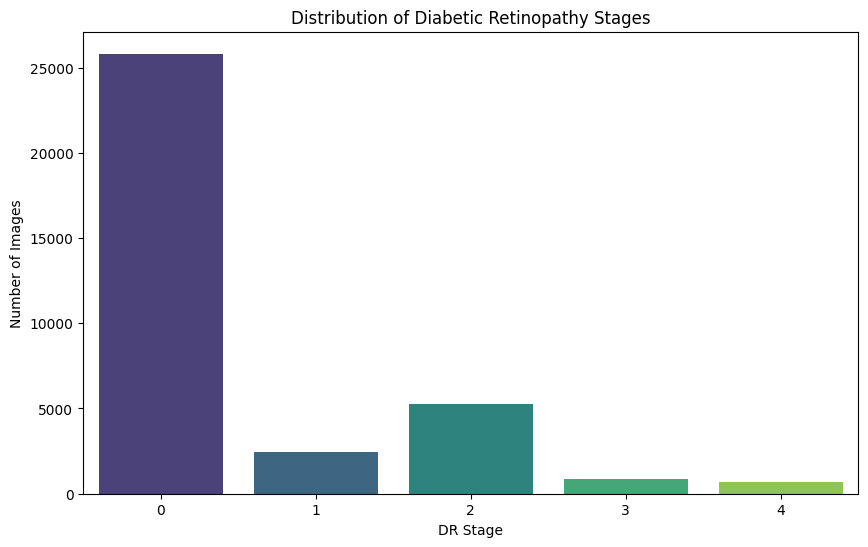


--- Class Distribution (Percentage) ---
level
0    73.48
1     6.95
2    15.07
3     2.49
4     2.02
Name: count, dtype: float64


In [2]:
print("\n--- Class Distribution ---")
class_counts = df['level'].value_counts().sort_index() # 진단명으로 정렬
print(class_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Diabetic Retinopathy Stages')
plt.xlabel('DR Stage')
plt.ylabel('Number of Images')
plt.show()

# 비율 계산
total_images_in_df = len(df)
print("\n--- Class Distribution (Percentage) ---")
print((class_counts / total_images_in_df * 100).round(2))

**각 단계별 특징 및 데이터의 품질 시각적으로 확인**

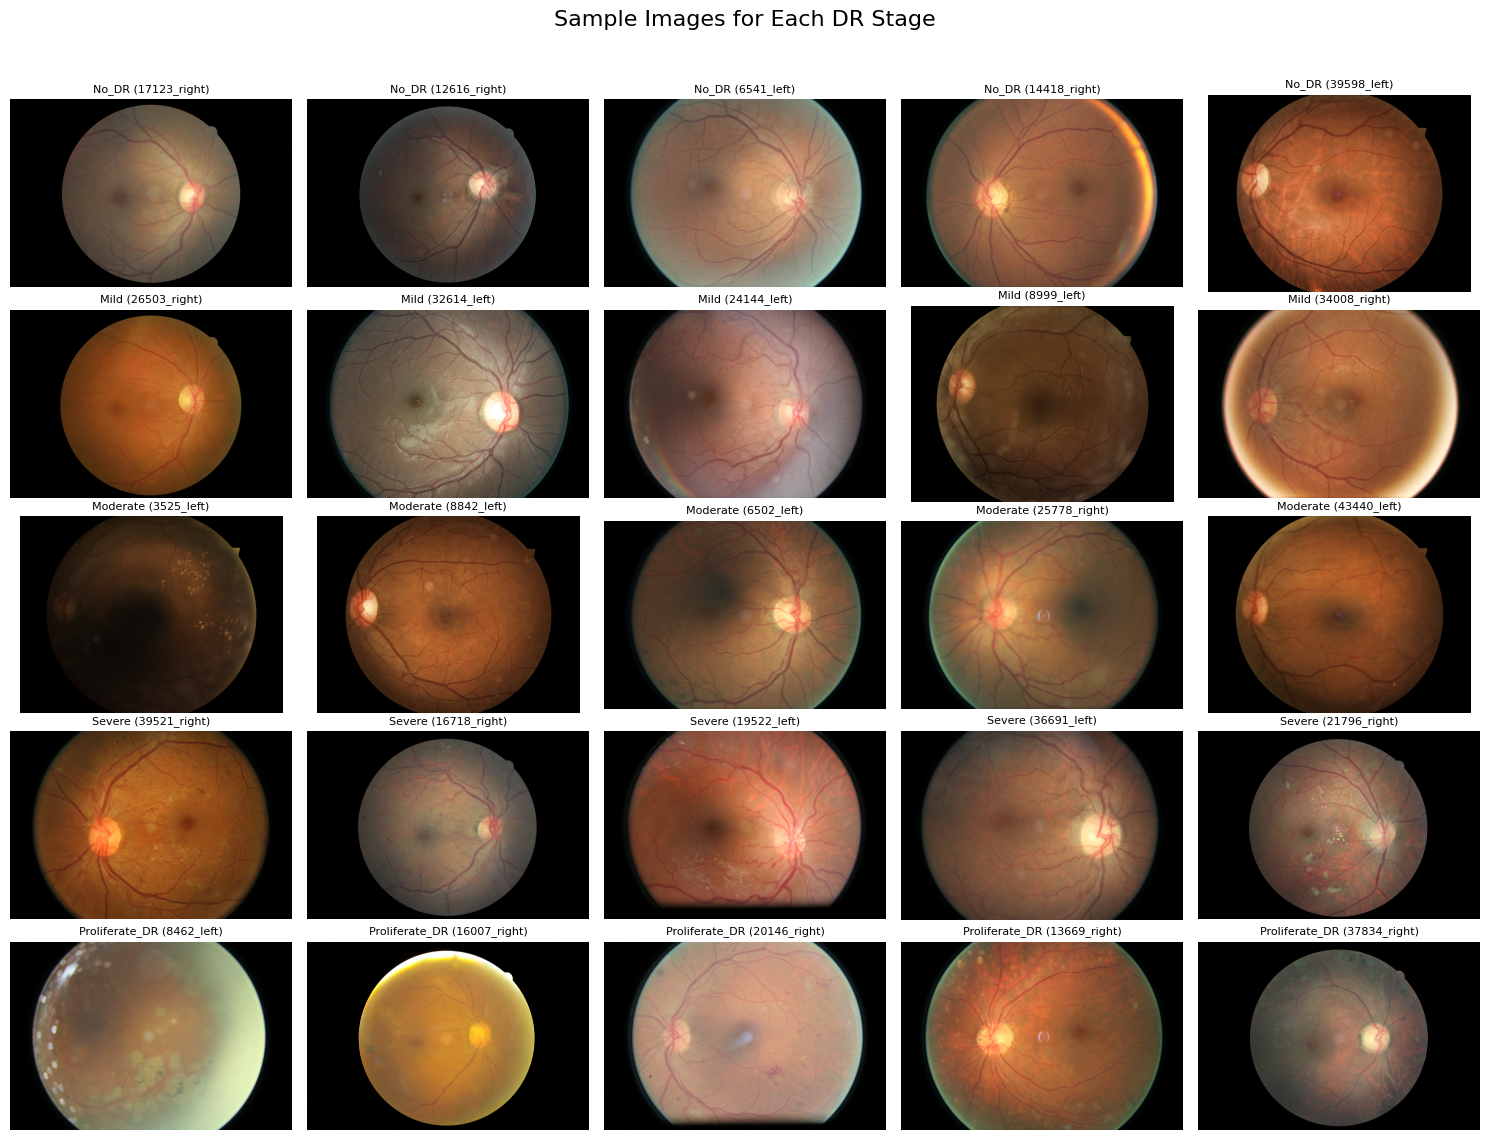


--- Checking Data Quality (Visual Inspection) ---
While viewing sample images from the previous step, pay attention to:
1. Bluriness or poor focus.
2. Uneven lighting or glare.
3. Dust, smudges, or other artifacts on the lens/image.
4. Areas of the retina that are not clearly visible.
5. Compression artifacts if images are heavily compressed (e.g., JPEG with low quality).

If significant quality issues are present, consider:
 - Applying additional pre-processing steps (e.g., contrast enhancement, noise reduction).
 - Filtering out extremely low-quality images if their number is small.


In [3]:
# 각 클래스별로 몇 개의 샘플 이미지를 볼 것인지 설정
samples_per_class = 5

plt.figure(figsize=(15, 12)) # 전체 플롯 크기 조정 (세로를 조금 더 늘림)

# label_mapping은 {'No_DR':0, 'Mild':1, ...} 형태입니다.
# 우리가 필요한 것은 숫자 레이블(0, 1, 2, 3, 4)로 데이터를 필터링하고
# 해당 레이블의 이름을 플롯 제목에 사용하는 것입니다.

# label_mapping을 순회하는 대신, 숫자 레이블(level)을 기준으로 순회합니다.
# sorted(label_mapping.values())는 [0, 1, 2, 3, 4]를 반환합니다.
for label_num in sorted(label_mapping.values()):
    # 숫자 레이블(label_num)에 해당하는 진단명(label_name)을 reverse_label_mapping에서 가져옵니다.
    label_name = reverse_label_mapping[label_num]

    # 해당 진단 레벨(숫자)에 해당하는 이미지들 필터링
    class_df = df[df['level'] == label_num] # <-- 여기가 핵심 변경! label_name 대신 label_num 사용

    # 샘플 이미지들을 무작위로 선택 (해당 클래스에 이미지가 충분하지 않을 경우를 대비하여 min 사용)
    sample_ids = class_df['image'].sample(min(samples_per_class, len(class_df)), random_state=42)

    for i, img_id in enumerate(sample_ids):
        # subplot 위치 계산
        # 5개 클래스 * samples_per_class + (현재 인덱스 + 1)
        plot_idx = label_num * samples_per_class + (i + 1)
        plt.subplot(len(label_mapping), samples_per_class, plot_idx)

        img_filename = img_id + '.jpeg' # 이미지 파일 확장자 .jpeg로 고정

        # 이미지 경로 구성: base_image_dir 바로 아래에 모든 이미지가 있다고 가정
        img_path = os.path.join(base_image_dir, img_filename) # <-- 여기가 핵심 변경! label_name 폴더 제거

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV는 BGR, Matplotlib은 RGB
                plt.imshow(img)
                plt.title(f"{label_name} ({img_id})", fontsize=8) # 제목에는 진단명 사용
                plt.axis('off')
            else:
                plt.title(f"Error loading {label_name} {img_id}")
                plt.axis('off')
        else:
            plt.title(f"Missing {label_name} {img_id}")
            plt.axis('off')

plt.suptitle('Sample Images for Each DR Stage', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # 제목 공간 확보
plt.show()

# 원본 데이터의 품질(노이즈, 아티팩트 등)
print("\n--- Checking Data Quality (Visual Inspection) ---")
print("While viewing sample images from the previous step, pay attention to:")
print("1. Bluriness or poor focus.")
print("2. Uneven lighting or glare.")
print("3. Dust, smudges, or other artifacts on the lens/image.")
print("4. Areas of the retina that are not clearly visible.")
print("5. Compression artifacts if images are heavily compressed (e.g., JPEG with low quality).")
print("\nIf significant quality issues are present, consider:")
print(" - Applying additional pre-processing steps (e.g., contrast enhancement, noise reduction).")
print(" - Filtering out extremely low-quality images if their number is small.")

In [5]:
# --- 단계 2: 이미지 사이즈 통일 (Resizing) ---

def resize_image_step(image, target_size=IMG_SIZE):
    """이미지 크기를 target_size로 조정합니다."""
    return cv2.resize(image, target_size)

print("\n--- Step 2: Image Resizing ---")

# 리사이징 실행
image_after_resize = resize_image_step(current_image)
image_after_resize_rgb = cv2.cvtColor(image_after_resize, cv2.COLOR_BGR2RGB)

# 결과 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(current_image_rgb)
plt.title(f"Before Resizing\nShape: {current_image_rgb.shape}", fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_after_resize_rgb)
plt.title(f"After Resizing to {IMG_WIDTH}x{IMG_HEIGHT}\nShape: {image_after_resize.shape}", fontsize=12)
plt.axis('off')

plt.suptitle("Image Preprocessing: Step 2 (Resizing)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"Image shape before resizing: {current_image.shape}")
print(f"Image shape after resizing: {image_after_resize.shape}")
print("Comment: The image dimensions are now uniformly fixed to the target size.")

current_image = image_after_resize.copy() # 다음 단계를 위해 현재 이미지 상태 업데이트
current_image_rgb = image_after_resize_rgb.copy()


--- Step 2: Image Resizing ---


NameError: name 'current_image' is not defined

In [14]:
# --- STEP 4: 고급 이미지 전처리 함수 정의 ---

# 모델의 입력 이미지 크기를 정의합니다. (224x224는 흔히 사용되는 크기)
IMG_HEIGHT, IMG_WIDTH = 224, 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
NUM_CLASSES = len(label_mapping) # 5개 클래스

# 단일 이미지를 전처리하는 함수
def preprocess_image_advanced(image_path, img_size=IMG_SIZE):
    image = cv2.imread(image_path)
    if image is None:
        # 이미지 로드 실패 시 None 반환. 추후 스킵 처리.
        # print(f"Warning: Could not read image at {image_path}. It might be corrupted or missing.")
        return None

    # 1. 컬러 이미지를 YCrCb 색 공간으로 변환 (밝기 채널에 CLAHE 적용)
    # YCrCb는 Y(밝기), Cr(적색-녹색 차이), Cb(청색-노란색 차이) 채널을 가집니다.
    img_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization) 객체 생성 및 적용
    # clipLimit: 대비 증폭을 제한하여 노이즈 과도 증폭을 방지합니다. 2.0이 일반적인 값입니다.
    # tileGridSize: 이미지를 나눌 그리드 크기. 작은 타일은 더 지역적인 대비 조절에 좋습니다.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Y (밝기) 채널에만 CLAHE 적용
    img_ycrcb[:, :, 0] = clahe.apply(img_ycrcb[:, :, 0])

    # 3. YCrCb를 다시 BGR(OpenCV 기본 색 공간)로 변환
    image = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2BGR)

    # 4. 이미지 크기 조정: 모든 이미지를 모델 입력에 맞는 동일한 크기로 리사이즈
    # 다양한 해상도의 이미지들을 딥러닝 모델에 입력하기 위해 동일한 크기로 통일합니다.
    image = cv2.resize(image, img_size)

    # 5. 픽셀 값 정규화: 0-255 범위의 픽셀 값을 0-1.0 범위로 변환합니다.
    # 이는 신경망이 데이터를 효율적으로 처리하고, 수렴 속도를 높이는 데 중요합니다.
    image = image / 255.0

    return image

print("Advanced image preprocessing function 'preprocess_image_advanced' defined.")

Advanced image preprocessing function 'preprocess_image_advanced' defined.


Modified 'preprocess_image_advanced' to return intermediate steps.

Visualizing preprocessing steps for image: diabetic-retinopathy-detection\train\10_left.jpeg


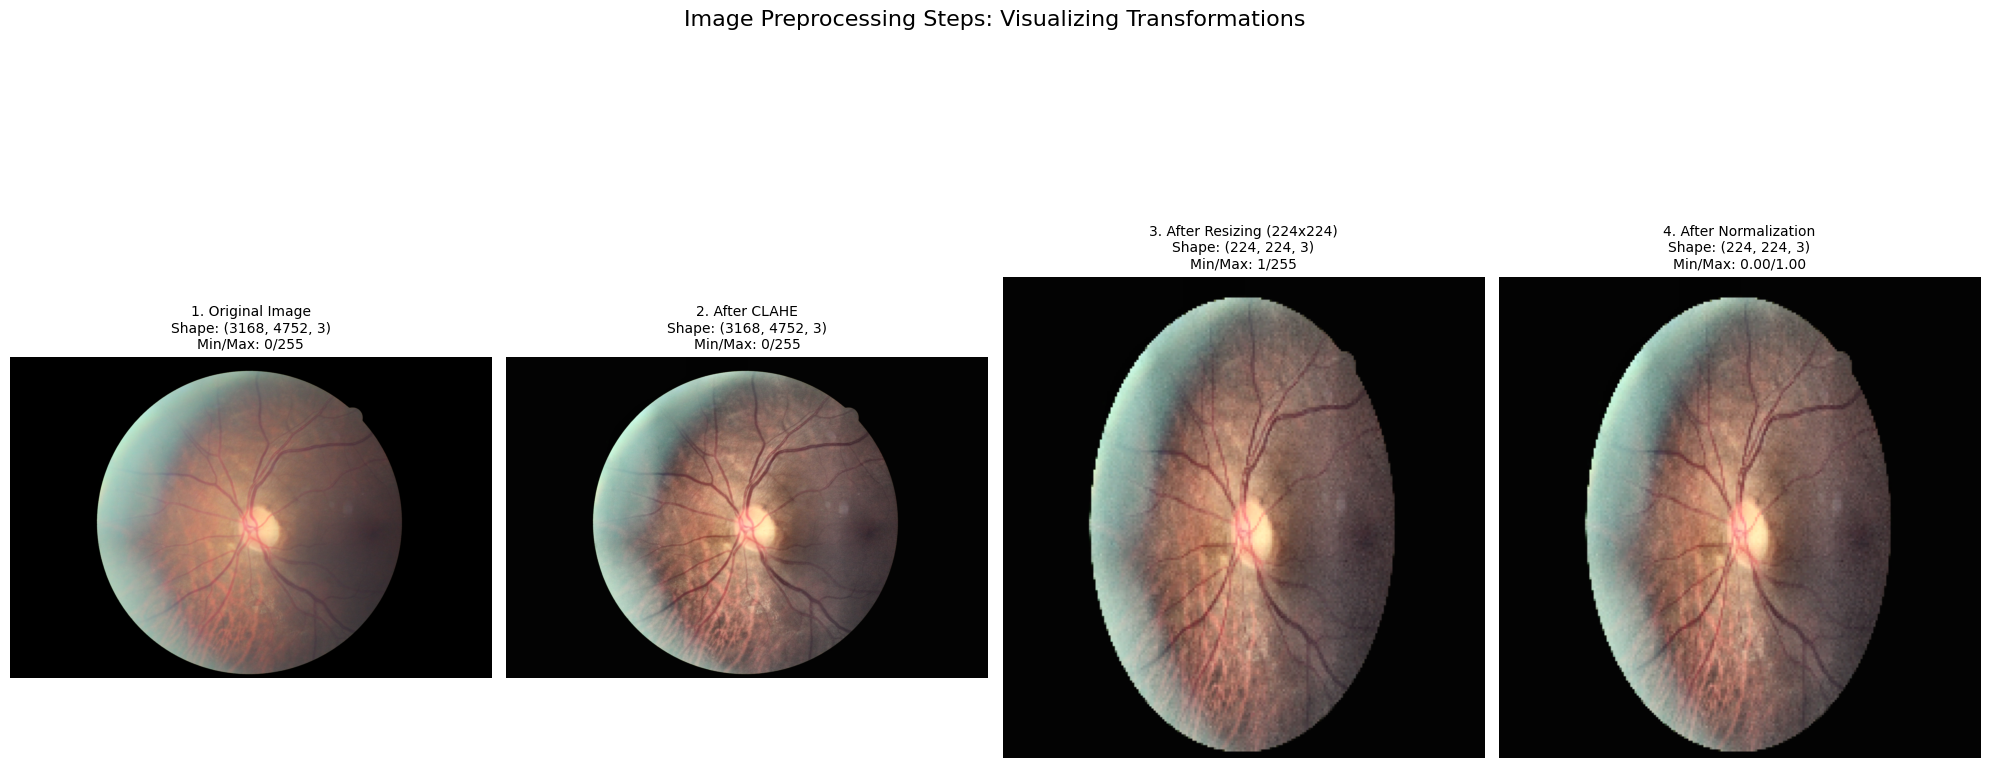


--- Summary of Preprocessing Changes ---
1.  **CLAHE:** Enhances contrast, making features like blood vessels and lesions more visible, especially in poorly lit or low-contrast areas. The image visually becomes sharper in detail, though overall color may slightly shift.
2.  **Resizing:** All images are uniformly scaled to a fixed size of 224x224 pixels. This is crucial for consistent input to deep learning models. The image's dimensions change, and it may appear compressed or stretched if the aspect ratio is not maintained (which is the case here).
3.  **Normalization:** Pixel values, originally from 0-255 (integers), are converted to floating-point numbers between 0.0 and 1.0. This change is not visually apparent but is essential for optimizing neural network training.


In [4]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np # 넘파이 추가

# --- STEP 4 함수 다시 정의 (여기서는 함수만 가져와 사용) ---
# 모델의 입력 이미지 크기를 정의합니다.
IMG_HEIGHT, IMG_WIDTH = 224, 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

def preprocess_image_advanced(image_path, img_size=IMG_SIZE):
    image = cv2.imread(image_path)
    if image is None:
        return None

    # 모든 중간 단계를 저장할 수 있도록 함수 내부 로직 변경
    original_image = image.copy() # 원본 이미지 복사

    # 1. 컬러 이미지를 YCrCb 색 공간으로 변환 (밝기 채널에 CLAHE 적용)
    img_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_ycrcb[:, :, 0] = clahe.apply(img_ycrcb[:, :, 0])
    image_after_clahe = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2BGR) # CLAHE 적용 후 BGR로 변환된 이미지

    # 2. 이미지 크기 조정 (리사이징)
    image_after_resize = cv2.resize(image_after_clahe, img_size)

    # 3. 픽셀 값 정규화
    image_after_normalize = image_after_resize / 255.0

    return original_image, image_after_clahe, image_after_resize, image_after_normalize

print("Modified 'preprocess_image_advanced' to return intermediate steps.")

# --- 전처리 전후 변화 확인을 위한 샘플 이미지 선택 및 시각화 ---

# df가 이미 로드되어 있어야 합니다.
if 'df' not in locals():
    print("DataFrame 'df' not found. Please run previous sections to load data.")
    exit()

# 예시로 'No_DR' 클래스의 첫 번째 이미지를 선택합니다.
# 다른 클래스나 무작위 이미지를 선택해도 됩니다.
sample_row = df[df['level'] == 0].iloc[0] # 'No_DR' 클래스 (level 0)의 첫 번째 이미지 선택
sample_img_id = sample_row['image']
sample_img_filename = sample_img_id + '.jpeg'
sample_img_path = os.path.join(base_image_dir, sample_img_filename)

print(f"\nVisualizing preprocessing steps for image: {sample_img_path}")

# 수정된 preprocess_image_advanced 함수 호출
results = preprocess_image_advanced(sample_img_path, IMG_SIZE)

if results is not None:
    original_image, image_after_clahe, image_after_resize, image_after_normalize = results

    plt.figure(figsize=(20, 10))

    # 1. 원본 이미지
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f"1. Original Image\nShape: {original_image.shape}\nMin/Max: {original_image.min()}/{original_image.max()}", fontsize=10)
    plt.axis('off')
    
    # 2. 리사이징 후 이미지
    plt.subplot(1, 4, 3)
    # 리사이징 후에는 이미지가 0-255 범위이므로, imshow는 정상적으로 표시됨
    plt.imshow(cv2.cvtColor(image_after_resize, cv2.COLOR_BGR2RGB))
    plt.title(f"3. After Resizing ({IMG_WIDTH}x{IMG_HEIGHT})\nShape: {image_after_resize.shape}\nMin/Max: {image_after_resize.min()}/{image_after_resize.max()}", fontsize=10)
    plt.axis('off')

    # 3. CLAHE 적용 후 이미지
    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(image_after_clahe, cv2.COLOR_BGR2RGB))
    plt.title(f"2. After CLAHE\nShape: {image_after_clahe.shape}\nMin/Max: {image_after_clahe.min()}/{image_after_clahe.max()}", fontsize=10)
    plt.axis('off')

    # 4. 정규화 후 이미지 (픽셀 값이 0-1이므로 imshow는 float 타입으로 처리)
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor((image_after_normalize * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)) # 시각화를 위해 0-255로 다시 스케일링
    # 또는 그냥 plt.imshow(image_after_normalize) 해도 잘 보입니다. Matplotlib이 float 이미지를 자동으로 처리
    plt.title(f"4. After Normalization\nShape: {image_after_normalize.shape}\nMin/Max: {image_after_normalize.min():.2f}/{image_after_normalize.max():.2f}", fontsize=10)
    plt.axis('off')

    plt.suptitle('Image Preprocessing Steps: Visualizing Transformations', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print(f"Could not load or preprocess the sample image: {sample_img_path}")

print("\n--- Summary of Preprocessing Changes ---")
print("1.  **CLAHE:** Enhances contrast, making features like blood vessels and lesions more visible, especially in poorly lit or low-contrast areas. The image visually becomes sharper in detail, though overall color may slightly shift.")
print(f"2.  **Resizing:** All images are uniformly scaled to a fixed size of {IMG_WIDTH}x{IMG_HEIGHT} pixels. This is crucial for consistent input to deep learning models. The image's dimensions change, and it may appear compressed or stretched if the aspect ratio is not maintained (which is the case here).")
print("3.  **Normalization:** Pixel values, originally from 0-255 (integers), are converted to floating-point numbers between 0.0 and 1.0. This change is not visually apparent but is essential for optimizing neural network training.")


--- Step 1: Image Resizing ---


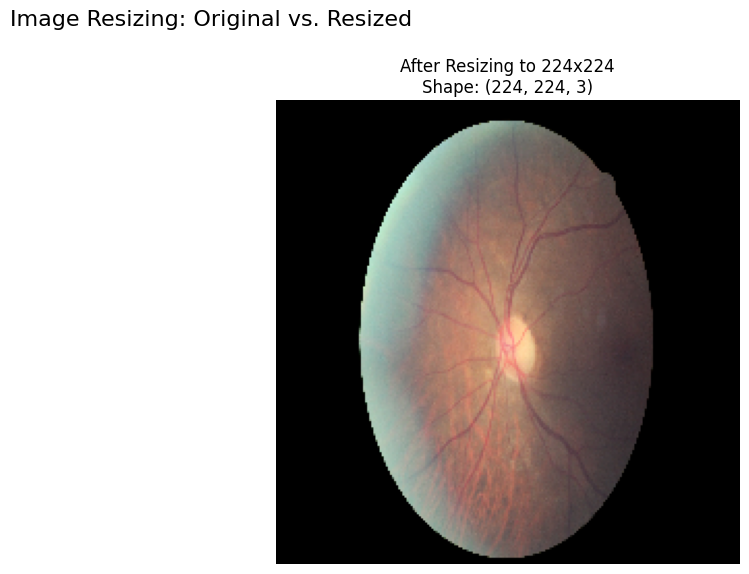

Original image shape: (3168, 4752, 3)
Resized image shape: (224, 224, 3)
Comment: The image dimensions are now uniformly fixed to the target size.


In [17]:
# --- 단계 1: 이미지 사이즈 통일 (Resizing) ---

def resize_image(image, target_size=IMG_SIZE):
    """
    이미지 크기를 target_size로 조정합니다.
    """
    resized_image = cv2.resize(image, target_size)
    return resized_image

print("\n--- Step 1: Image Resizing ---")

# 리사이징 실행
image_after_resize = resize_image(original_image)

# 결과 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_after_resize, cv2.COLOR_BGR2RGB))
plt.title(f"After Resizing to {IMG_WIDTH}x{IMG_HEIGHT}\nShape: {image_after_resize.shape}", fontsize=12)
plt.axis('off')

plt.suptitle("Image Resizing: Original vs. Resized", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"Original image shape: {original_image.shape}")
print(f"Resized image shape: {image_after_resize.shape}")
print("Comment: The image dimensions are now uniformly fixed to the target size.")